# Question :

Is there a relationship between customer region and certain product categories? If so, we can  help run more highly targeted sales and marketing programs for increasing sales of certain products to certain market regions 

In [1]:

import pandas as pd
import sqlite3


import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

In [9]:

conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()


def get_table(cur, table):
    cur.execute(f"SELECT * from {table};")
    df = pd.DataFrame(cur.fetchall())
    df.columns = [desc[0] for desc in cur.description]
    return df



cur.execute("""SELECT name from sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables


,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


In [33]:
#information based on customer region and product category

cur.execute("""
          SELECT cat.CategoryName, c.Region,
          COUNT(Distinct c.Id) as Customers, SUM(od.Quantity) as TotalUnits, 
          SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) as TotalSpending, COUNT(o.Id) as TotalOrders
          FROM OrderDetail od
          JOIN 'Order' o ON od.OrderId = o.Id
          JOIN Customer c ON o.CustomerId = c.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON p.CategoryId = cat.Id
          GROUP BY 1,2
          ;
          """)
region_data = pd.DataFrame(cur.fetchall())
region_data.columns = [x[0] for x in cur.description]
display(region_data.head(20))
region_data.info()

,CategoryName,Region,Customers,TotalUnits,TotalSpending,TotalOrders
0,Beverages,British Isles,8,702,10421.4200,35
1,Beverages,Central America,3,190,6235.0000,14
2,Beverages,Eastern Europe,1,71,828.5000,6
3,Beverages,North America,14,1919,71797.0350,72
4,Beverages,Northern Europe,4,744,24189.6950,32
5,Beverages,Scandinavia,3,155,4938.4000,14
6,Beverages,South America,13,1280,35099.7950,60
7,Beverages,Southern Europe,8,318,3408.5400,22
8,Beverages,Western Europe,25,3732,98333.2950,134
9,Condiments,British Isles,5,390,7893.5500,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CategoryName   71 non-null     object 
 1   Region         71 non-null     object 
 2   Customers      71 non-null     int64  
 3   TotalUnits     71 non-null     int64  
 4   TotalSpending  71 non-null     float64
 5   TotalOrders    71 non-null     int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 3.5+ KB


In [17]:
def make_dataset(dataframe, group_col_name, y_axis_col_name):
   

   # make list of lists
    legend = list(dataframe[group_col_name].unique())
    dataset= []
    for category in legend:
        cat_group = []
        for i in dataframe.index:
            if dataframe[group_col_name][i] == category:
                cat_group.append(dataframe[y_axis_col_name][i])
        dataset.append(cat_group)
    return dataset

In [18]:
def stacked_bar_plot(dataframe, group_col_name, x_axis_col_name, 
                     y_axis_col_name, dataset=None, auto_dataset=False, figsize=(15,8)):
   
   
    if auto_dataset:
        dataset = make_dataset(dataframe, group_col_name, y_axis_col_name)
    legend = list(dataframe[group_col_name].unique())
    X_AXIS = list(dataframe[x_axis_col_name].unique())
    ind = np.arange(len(dataset[0]))
    
    plt.figure(figsize=figsize)
    bottom = np.array(dataset[0])
    for i in list(range(len(dataset))):
        if i == 0:
            plt.bar(ind, dataset[i], label=legend[i])
        else:
            plt.bar(ind, dataset[i], label=legend[i], bottom=bottom)
            bottom += np.array(dataset[i])

    plt.yticks(fontsize=12)
    plt.ylabel(f' {y_axis_col_name} by {group_col_name}', fontsize=12)
    plt.xticks(ind, X_AXIS, rotation=45, fontsize=12)
    plt.xlabel(f'{x_axis_col_name}', fontsize=12)
    plt.title(f'{group_col_name} {y_axis_col_name} by {x_axis_col_name}', fontsize=16)
    plt.legend(fontsize=12);
    pass

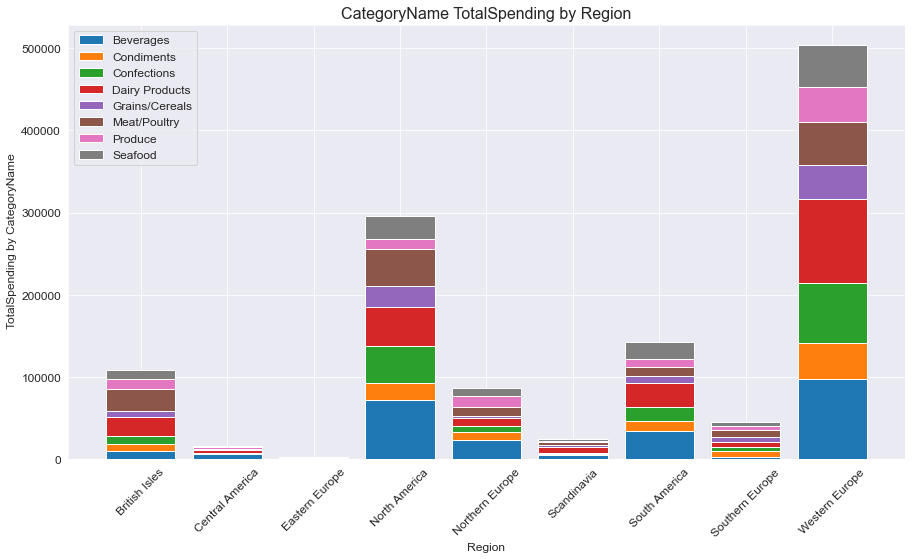

In [22]:

# Plot TotalSpending in each Region for each Product Category
dataset = make_dataset(region_data, 'CategoryName', 'TotalSpending')
# must add in a value for Grains/Cereals since Eastern Europe did not purchase any
dataset[4].insert(2,0)
stacked_bar_plot(region_data, 'CategoryName','Region', 'TotalSpending', dataset=dataset)

These stacked bar graphs give us a cursory idea of proportionally how much of each category every region is ordering, how much money is spent on each category, and the absolute differences in the total number of units and dollars spent by each region.

I would recommend that salespersons readjust their sales efforts according to the table below. 

| Region | Product Categories to Market more Aggressively | Product Categories to Market Less Aggressively |
|:----- |:-----:|:-----:|
| British Isles | Dairy Products , Meat/Poultry, Produce | Beverages, , Grains/Cereals , condiments ,Confections|
| North America | Beverages, Confections,Dairy Products, Meat/Poultry | Produce ,Grains/Cereal ,condiments |
| Northern Europe | Beverages, Produce | Confections, Dairy Products, Grains/Cereals, Meat/Poultry |
| Western Europe | Beverages,Dairy Products , Confections | Grains/Cereals, condiments |
| South America | Beverages, Dairy Products | Grains/Cereals,Meat/Poultry, Produce|





These lists detail which regions spend proportionately more on certain categories as compared to the population ratios . This means that the listed product categories are in higher demand in the listed regions than one could normally expect, implying that it should be easier to sell more of those products (and possibly at a higher price) in those regions than others, especially when acquiring new customers.

However, this does not mean that existing sales of low-demand product-region combinations should be neglected to the point where they decrease. This study merely suggests that no additional effort be spent increasing those combinations.